# Загрузка зависимостей

In [1]:
!nvidia-smi

Thu Sep 18 11:56:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8             10W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Всё, что нужно устанавливается через uv

In [2]:
!pip install uv
!git clone https://github.com/jezvgg/RL4VLA.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 67.1 MB/s eta 0:00:00:00:0100:01
Cloning into 'RL4VLA'...
remote: Enumerating objects: 783, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 783 (delta 28), reused 33 (delta 19), pack-reused 711 (from 1)
Receiving objects: 100% (783/783), 91.96 MiB | 44.92 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [3]:
!cd RL4VLA && uv pip install -r pyproject.toml --system
!cd RL4VLA/ManiSkill && uv pip install -e . --system && cd ../..
!cd RL4VLA/SimplerEnv && uv pip install -e . --system && cd ../..

Using Python 3.11.11 environment at: /usr
Resolved 120 packages in 855ms                                       
⠙ Preparing packages... (0/19)                                                  
⠙ Preparing packages... (0/19)---     0 B/34.78 KiB                     
⠙ Preparing packages... (0/19)--- 14.87 KiB/34.78 KiB                   
semantic-version ------------------------------     0 B/15.19 KiB
⠙ Preparing packages... (0/19)--- 14.87 KiB/34.78 KiB                   
semantic-version ------------------------------ 14.82 KiB/15.19 KiB
⠙ Preparing packages... (0/19)--- 14.87 KiB/34.78 KiB                   
semantic-version ------------------------------ 14.82 KiB/15.19 KiB
configobj  ------------------------------ 14.87 KiB/34.78 KiB
⠙ Preparing packages... (0/19)---     0 B/114.73 KiB                    
semantic-version ------------------------------ 14.82 KiB/15.19 KiB
configobj  ------------------------------ 14.87 KiB/34.78 KiB
ipykernel  ------------------------------     0 

In [4]:
!apt-get install -yqq --no-install-recommends libvulkan-dev vulkan-tools
!mkdir -p /usr/share/vulkan/icd.d
!wget -q -P /usr/share/vulkan/icd.d https://raw.githubusercontent.com/haosulab/ManiSkill/main/docker/nvidia_icd.json
!wget -q -O /usr/share/glvnd/egl_vendor.d/10_nvidia.json https://raw.githubusercontent.com/haosulab/ManiSkill/main/docker/10_nvidia.json
!vulkaninfo | head -n 5

Selecting previously unselected package libvulkan1:amd64.
(Reading database ... 128691 files and directories currently installed.)
Preparing to unpack .../libvulkan1_1.3.204.1-2_amd64.deb ...
Unpacking libvulkan1:amd64 (1.3.204.1-2) ...
Selecting previously unselected package libvulkan-dev:amd64.
Preparing to unpack .../libvulkan-dev_1.3.204.1-2_amd64.deb ...
Unpacking libvulkan-dev:amd64 (1.3.204.1-2) ...
Selecting previously unselected package vulkan-tools.
Preparing to unpack .../vulkan-tools_1.3.204.0+dfsg1-1_amd64.deb ...
Unpacking vulkan-tools (1.3.204.0+dfsg1-1) ...
Setting up libvulkan1:amd64 (1.3.204.1-2) ...
Setting up libvulkan-dev:amd64 (1.3.204.1-2) ...
Setting up vulkan-tools (1.3.204.0+dfsg1-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.8) ...
/sbin/ldconfig.real: /usr/local/lib/libtcm.so.1 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libumf.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtcm_debug.so.1 is not a symbolic link



In [5]:
import site
site.main()

In [7]:
import comet_ml

comet_ml.login(project_name="AIRI_Task")

Please paste your Comet API key from https://www.comet.com/api/my/settings/
(api key may not show as you type)


COMET INFO: Valid Comet API Key saved in /root/.comet.config (set COMET_CONFIG to change where it is saved).


In [ ]:
# !export COMET_API_KEY=
!export COMET_WORKSPACE=jezvgg
!export COMET_PROJECT=AIRI_Task

# Collecting a datasets
for Requried step 3

## Collect base dataset

In [43]:
import gymnasium as gym
from mani_skill.envs import *

task = 'PutOnPlateInScene25MultiCarrot-v1'
env = gym.make(task, 
               num_envs=1,
               obs_mode='rgb+segmentation')
question = 'What objects are in the scene?'

In [44]:
from tqdm import tqdm
from pathlib import Path
from PIL import Image

experiment_config = comet_ml.ExperimentConfig(
    name="Collecting objects dataset",
)
experiment = comet_ml.start(project='AIRI_Task', experiment_config=experiment_config)
comet_dataset = comet_ml.Artifact(name="BaseDataset", artifact_type="dataset")

start_seed = 42 
corrects = []
images_path = Path('./images')
images_path.mkdir(exist_ok=True)
dataset_path = Path('./base_data.csv')
if (dataset_path.exists() and \
    input(f"{dataset_path} already exsits, you want to owerwrite it? [Y/n]") == 'Y') or \
    not dataset_path.exists():
    with open(dataset_path, 'w') as f: f.write('question,image_path,answer\n')

for i in tqdm(range(250)):
    obs, reset_info = env.reset(seed = start_seed + i)
    image = Image.fromarray(obs['sensor_data']['3rd_view_camera']['rgb'].detach().cpu().numpy()[0])
    image_path = images_path / f'image{i}.png'
    image.save(image_path)

    action_carrot = env.unwrapped.carrot_names[env.unwrapped.select_carrot_ids[0]].split('_')[1]
    extra_carrot = env.unwrapped.carrot_names[env.unwrapped.select_extra_ids[0]].split('_')[1]
    plate = env.unwrapped.plate_names[env.unwrapped.select_plate_ids[0]].split('_')[1]
    answer = ','.join([action_carrot, extra_carrot, plate]).capitalize()

    data_row = ','.join([question, str(image_path), f'"{answer}"']) + '\n'
    with open(dataset_path, '+a') as f:
        f.write(data_row)
    
comet_dataset.add(images_path)
comet_dataset.add(dataset_path)

experiment.log_artifact(comet_dataset)

experiment.end()

## Collect extended dataset

In [4]:
import gymnasium as gym
from mani_skill.envs import *

task = 'PutOnPlateInScene25MultiCarrot-v1'
envs = [gym.make(task, 
        num_envs=1,
        obs_mode='rgb+segmentation') for task in ['PutOnPlateInScene25Main-v3', 'PutOnPlateInScene25MultiCarrot-v1']]

task_questions = [
    'What objects do you see?',
    'What color or material is the table?',
    'What is on the table?',
    'What can you eat on the table?',
    'What is closest to the edge of the table?',
    'What is most likely to fall off a table?'
]

Generative answers

In [5]:
from mani_skill.envs.sapien_env import BaseEnv

table_materials = [
    'wood',
    'plastic',
    'black',
    'gray',
    'wood',
    'wood',
    'yellow',
    'granite',
    'gray',
    'white',
    'granite',
    'pink',
    'wood',
    'grass',
    'wood',
    'colorful',
    'glass',
    'green',
    'pink',
    'stone',
    'wood'
]

eatable = ['001_carrot_simpler', '003_bread_1', '005_7up can_1', '006_zuchinni_1', '007_ketchup bottle_1', '008_watering can_1', '011_fast food cup_1', '013_banana_1', '014_hamburger_1', '016_BBQ sauce_1', '018_pepper_1', '020_potato_1', '021_baguette_1', '022_champagne glass_1', '024_onion_1']
eatable = set([obj.split('_')[1] for obj in eatable])

table_open_sides = [
    [2],
    [1,2],
    [1,2],
    [0,1,2],
    [1,2],
    [0,1,2],
    [0,1,2],
    [0,1,2],
    [1,2],
    [2],
    [0,1,2],
    [1,2],
    [0,1,2],
    [0,1,2],
    [0,1,2],
    [2],
    [0,1,2],
    [0,1,2],
    [2],
    [0,1,2],
    [0,1,2]
]


def get_objects(env: BaseEnv) -> list:
    objects = []
    objects.append(env.unwrapped.carrot_names[env.unwrapped.select_carrot_ids[0]].split('_')[1])
    objects.append(env.unwrapped.plate_names[env.unwrapped.select_plate_ids[0]].split('_')[1])
    if hasattr(env.unwrapped, 'select_extra_ids'):
        objects.append(env.unwrapped.carrot_names[env.unwrapped.select_extra_ids[0]].split('_')[1])
    return objects


def get_objects_all(env: BaseEnv) -> list:
    objects = get_objects(env)
    objects += ['manipulator', 'table']
    return objects


def get_table_material(env: BaseEnv) -> list:
    material = table_materials[env.unwrapped.select_overlay_ids[0]]
    return [material]


def get_eatable(env: BaseEnv) -> list:
    objects = get_objects(env)
    eatable_objects = set(objects) & eatable
    return list(eatable_objects)


def get_edge_distance(object: tuple[int, int]) -> tuple[int, int, int]:
    object = np.array(object) * np.array([640, 480])
    dotI = np.array([160, 71])
    dotII = np.array([69, 215])
    dotIII = np.array([0, 179])
    dotIV = np.array([0, 318])
    dotV = np.array([310,479])

    s1 = dotI - dotII
    edge1_distance = np.abs((np.cross(object, dotI) * s1)) / np.abs(s1)

    s2 = dotI - dotIII
    edge2_distance = np.abs((np.cross(object, dotI) * s2)) / np.abs(s2)

    s3 = dotIV - dotV
    edge3_distance = np.abs((np.cross(object, dotV) * s3)) / np.abs(s3)

    return edge1_distance, edge2_distance, edge3_distance


def get_closest_to_edge(env: BaseEnv) -> list:
    distances = {}
    objects_position = env.unwrapped.xyz_configs[env.unwrapped.select_pos_ids][:, :2]

    carrot_object_name = env.unwrapped.carrot_names[env.unwrapped.select_carrot_ids[0]].split('_')[1]
    carrot_distance = np.min(get_edge_distance(objects_position[0]))
    distances[carrot_distance] = carrot_object_name

    plate_object_name = env.unwrapped.plate_names[env.unwrapped.select_plate_ids[0]].split('_')[1]
    plate_distance = np.min(get_edge_distance(objects_position[1]))
    distances[plate_distance] = plate_object_name

    if hasattr(env.unwrapped, 'select_extra_ids'):
        extra_object_name = env.unwrapped.carrot_names[env.unwrapped.select_extra_ids[0]].split('_')[1]
        extra_distance = np.min(get_edge_distance(objects_position[2]))
        distances[extra_distance] = extra_object_name

    return [distances[min(distances.keys())]]


def get_fall_objects(env: BaseEnv) -> list:
    distances = {}
    objects_position = env.unwrapped.xyz_configs[env.unwrapped.select_pos_ids][:, :2]
    sides = table_open_sides[env.unwrapped.select_overlay_ids[0]]

    carrot_object_name = env.unwrapped.carrot_names[env.unwrapped.select_carrot_ids[0]].split('_')[1]
    carrot_distance = np.array(get_edge_distance(objects_position[0]))[sides].min()
    distances[carrot_distance] = carrot_object_name

    plate_object_name = env.unwrapped.plate_names[env.unwrapped.select_plate_ids[0]].split('_')[1]
    plate_distance = np.array(get_edge_distance(objects_position[1]))[sides].min()
    distances[plate_distance] = plate_object_name

    if hasattr(env.unwrapped, 'select_extra_ids'):
        extra_object_name = env.unwrapped.carrot_names[env.unwrapped.select_extra_ids[0]].split('_')[1]
        extra_distance = np.array(get_edge_distance(objects_position[2]))[sides].min()
        distances[extra_distance] = extra_object_name

    return [distances[min(distances.keys())]]

task_answers = [
    get_objects_all,
    get_table_material,
    get_objects,
    get_eatable,
    get_closest_to_edge,
    get_fall_objects
]

In [7]:
from tqdm import tqdm
from pathlib import Path
from PIL import Image

experiment_config = comet_ml.ExperimentConfig(
    name="Collecting extended dataset",
)
experiment = comet_ml.start(project='AIRI_Task', experiment_config=experiment_config)
comet_dataset = comet_ml.Artifact(name="ExtendedDataset", artifact_type="dataset")

start_seed = 42 
corrects = []
images_path = Path('./images')
images_path.mkdir(exist_ok=True)
dataset_path = Path('./extended_data.csv')
if (dataset_path.exists() and \
    input(f"{dataset_path} already exsits, you want to owerwrite it? [Y/n]") == 'Y') or \
    not dataset_path.exists():
    with open(dataset_path, 'w') as f: 
        dataset_head = ','.join([f"question{i},answer{i}" for i in range(len(task_questions))]) + ',image_path\n'
        f.write(dataset_head)


for i in tqdm(range(250)):
    for env in envs:
        obs, reset_info = env.reset(seed = start_seed + i)
        image = Image.fromarray(obs['sensor_data']['3rd_view_camera']['rgb'].detach().cpu().numpy()[0])
        image_path = images_path / f'image{i}.png'
        image.save(image_path)

        QA = [question+','+f"\"{(';'.join(answer_function(env)) or 'nothing').capitalize()}\"" \
                for question, answer_function in zip(task_questions, task_answers)]
        # print(QA)
        data_row = ','.join(QA) + ',' + str(image_path) + '\n'
        with open(dataset_path, '+a') as f:
            f.write(data_row)
    
comet_dataset.add(images_path)
comet_dataset.add(dataset_path)

experiment.log_artifact(comet_dataset)

experiment.end()

# Zero-shot evaluation
Required Step 1 and 2

## Base dataset evaluation
Required Step 2

In [11]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")
model = AutoModelForImageTextToText.from_pretrained(
    "HuggingFaceTB/SmolVLM-Instruct",
    torch_dtype=torch.bfloat16
).to(DEVICE)

2025-09-18 07:00:10.634128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758178810.831849      71 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758178810.889939      71 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/429 [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/4.49G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

In [15]:
from tqdm import tqdm
from collections import defaultdict
from pathlib import Path
from datasets import load_dataset
from PIL import Image


experiment_config = comet_ml.ExperimentConfig(
    name="Base dataset evaluating",
)
experiment = comet_ml.start(project='AIRI_Task', experiment_config=experiment_config)
experiment.add_tag('eval')
dataset_path = Path('./dataset')
if not dataset_path.exists():
    dataset_path.mkdir()
    artefact = experiment.get_artifact('BaseDataset') # latest
    artefact.download(dataset_path, overwrite_strategy="PRESERVE")
dataset = load_dataset('csv', data_files=str(dataset_path / 'base_data.csv'), split='train')


start_seed = 42 # Объявим начальный сид, чтоб потом детерменированно создавать среды для наилучшего воспроизведения
corrects = []
objects_stats = defaultdict(int)


for i in tqdm(range(len(dataset))):
    image_path = dataset_path / dataset[i]['image_path']
    image = Image.open(image_path)
    messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", 'text': dataset[i]['question']}
                ]
            }
        ]
    
    prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=prompt, images=[image], return_tensors="pt")
    inputs = inputs.to(DEVICE)
        
    generated_ids = model.generate(**inputs, max_new_tokens=500)
    generated_texts: list[str] = processor.batch_decode(
        generated_ids,
        skip_special_tokens=True,
    )

    keywords: list[str] = dataset[i]['answer'].split(',')
    correct = True
    for keyword in keywords:
        done = keyword.lower() in generated_texts[0].split('\n')[-1].lower()
        if not done: objects_stats[keyword] += 1
        correct &= done
    corrects.append(correct)

    experiment.log_metric("success_rate", (sum(corrects) / len(corrects))*100, step=i)
    experiment.log_others(objects_stats)

print(f"SR: {(sum(corrects) / len(corrects))*100:.2f}%")

experiment.end()

COMET INFO: An experiment with the same configuration options is already running and will be reused.
100%|██████████| 250/250 [32:41<00:00,  7.85s/it]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Base dataset evaluating
COMET INFO:     url                   : https://www.comet.com/jezvgg/airi-task/1b68527ab0aa4d72b64200db319ac2aa
COMET INFO:   Downloads:
COMET INFO:     artifact assets : 251 (73.12 MB)
COMET INFO:     artifacts       : 1
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     success_rate [250] : (0.0, 5.5045871559633035)
COMET INFO:   Others:
COMET INFO:     7up can        : 22
COMET INFO:     Banana         : 1
COMET INFO:     Bbq sauce      : 17
COMET INFO:     Bread      

SR: 4.00%


COMET INFO: Please wait for metadata to finish uploading (timeout is 3600 seconds)
COMET INFO: Uploading 62 metrics, params and output messages


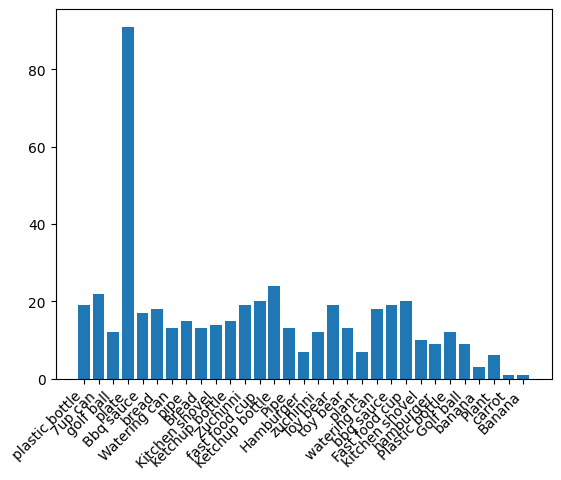

In [16]:
import matplotlib.pyplot as plt

plt.xticks(rotation=45, ha='right')
plt.bar(objects_stats.keys(), objects_stats.values());

## Extended dataset evaluation
Requried Step 1

In [8]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")
model = AutoModelForImageTextToText.from_pretrained(
    "HuggingFaceTB/SmolVLM-Instruct",
    torch_dtype=torch.bfloat16
).to(DEVICE)

In [23]:
from tqdm import tqdm
from collections import defaultdict
from pathlib import Path
from datasets import load_dataset
from PIL import Image


experiment_config = comet_ml.ExperimentConfig(
    name="Extended dataset evaluating",
)
experiment = comet_ml.start(project='AIRI_Task', experiment_config=experiment_config)
experiment.add_tag('eval')
dataset_path = Path('./dataset')
if not dataset_path.exists():
    dataset_path.mkdir()
    artefact = experiment.get_artifact('ExtendedDataset') # latest
    artefact.download(dataset_path, overwrite_strategy="PRESERVE")
dataset = load_dataset('csv', data_files=str(dataset_path / 'extended_data.csv'), split='train')


start_seed = 42 # Объявим начальный сид, чтоб потом детерменированно создавать среды для наилучшего воспроизведения
corrects = []
objects_stats = defaultdict(lambda: defaultdict(int))


for i in tqdm(range(len(dataset))):
    image_path = dataset_path / dataset['image_path'][i]
    image = Image.open(image_path)
    for j in range(dataset.shape[1] // 2):
        messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "image"},
                        {"type": "text", 'text': dataset[f'question{j}'][i]}
                    ]
                }
            ]
        
        prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(text=prompt, images=[image], return_tensors="pt")
        inputs = inputs.to(DEVICE)
            
        generated_ids = model.generate(**inputs, max_new_tokens=500)
        generated_texts: list[str] = processor.batch_decode(
            generated_ids,
            skip_special_tokens=True,
        )

        keywords: list[str] = dataset[f'answer{j}'][i].split(';')
        correct = True
        for keyword in keywords:
            done = keyword.lower() in generated_texts[0].split('\n')[-1].lower()
            if not done: objects_stats[dataset[f'question{j}'][i]][keyword] += 1
            correct &= done
        corrects.append(correct)

    experiment.log_metric("success_rate", (sum(corrects) / len(corrects))*100, step=i)
    experiment.log_others(objects_stats)

print(f"SR: {(sum(corrects) / len(corrects))*100:.2f}%")

experiment.end()

COMET INFO: An experiment with the same configuration options is already running and will be reused.
COMET INFO: Artifact 'jezvgg/ExtendedDataset:9.0.0' download has been started asynchronously
COMET INFO: Still downloading 251 file(s), remaining 73.26 MB/73.26 MB
COMET INFO: Artifact 'jezvgg/ExtendedDataset:9.0.0' has been successfully downloaded


Generating train split: 0 examples [00:00, ? examples/s]

 10%|█         | 50/500 [36:02<5:24:25, 43.26s/it]


KeyboardInterrupt: 

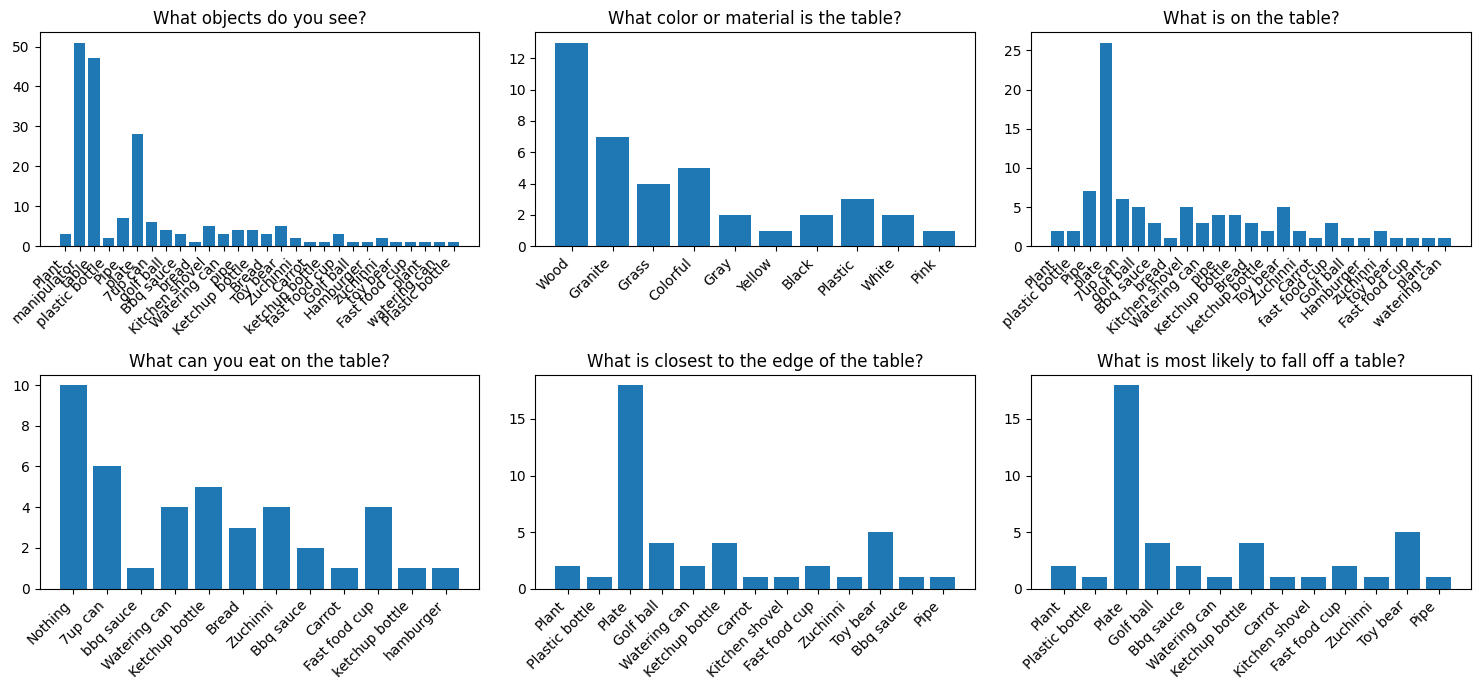

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

for i in range(2):
    for j in range(3):
        plt.subplot(2, 3, i*3+(j+1))
        question = list(objects_stats.keys())[i*3+j]
        plt.title(question)
        plt.xticks(rotation=45, ha='right')
        if not list(objects_stats[question].values()): continue
        plt.bar(objects_stats[question].keys(), objects_stats[question].values())
plt.tight_layout()
plt.show();

# Supervised fine-tuning VLM
Reuired step 3

## SFT on Base dataset

In [9]:
from pathlib import Path
import pandas as pd
from datasets import load_dataset

experiment_config = comet_ml.ExperimentConfig(
    name="Base dataset SFT",
)
experiment = comet_ml.start(project='AIRI_Task', experiment_config=experiment_config)
experiment.add_tag('training')
dataset_path = Path('./dataset')
if not dataset_path.exists():
    dataset_path.mkdir()
    artefact = experiment.get_artifact('BaseDataset') # latest
    artefact.download(dataset_path, overwrite_strategy="PRESERVE")
data = load_dataset('csv', data_files=str(dataset_path / 'base_data.csv'), split="train")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/jezvgg/airi-task/812d6be9355a4ab5a536728b5c80c087

COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Artifact 'jezvgg/BaseDataset:7.0.0' download has been started asynchronously
COMET INFO: Still downloading 251 file(s), remaining 73.12 MB/73.12 MB
COMET INFO: Artifact 'jezvgg/BaseDataset:7.0.0' has been successfully downloaded


Generating train split: 0 examples [00:00, ? examples/s]

In [10]:
from PIL import Image

def format_data(row):
    image_path = dataset_path / row['image_path']
    image = Image.open(image_path)
    return {
        "images": [image],
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "image": image,
                    },
                    {
                        "type": "text",
                        "text": row["question"],
                    },
                ],
            },
            {
                "role": "assistant",
                "content": [{"type": "text", "text": row["answer"]}],
            },
        ],
    }


train = [format_data(data[i]) for i in range(int(len(data)*0.8))]
val = [format_data(data[i]) for i in range(int(len(data)*0.8),int(len(data)*0.9))]
test = [format_data(data[i]) for i in range(int(len(data)*0.9), len(data))]

In [12]:
from transformers import BitsAndBytesConfig, AutoProcessor, Idefics3ForConditionalGeneration
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

model = Idefics3ForConditionalGeneration.from_pretrained(
    "HuggingFaceTB/SmolVLM-Instruct",
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
)
processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/429 [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

In [13]:
from peft import LoraConfig

peft_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=["down_proj", "o_proj", "k_proj", "q_proj", "gate_proj", "up_proj", "v_proj"],
    use_dora=True,
    init_lora_weights="gaussian",
)

In [14]:
from trl import SFTConfig

training_args = SFTConfig(
    output_dir="./",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    warmup_steps=50,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=25,
    save_strategy="steps",
    save_steps=25,
    save_total_limit=1,
    optim="adamw_torch_fused",
    bf16=True,
    push_to_hub=False,
    report_to="comet_ml",
    max_length=None,
)

In [15]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train,
    eval_dataset=val,
    peft_config=peft_config,
    processing_class=processor,
)

In [16]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 49154, 'bos_token_id': 1, 'pad_token_id': 2}.
COMET INFO: An experiment with the same configuration options is already running and will be reused.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.65 GiB. GPU 0 has a total capacity of 14.74 GiB of which 394.12 MiB is free. Process 4664 has 14.35 GiB memory in use. Of the allocated memory 12.33 GiB is allocated by PyTorch, and 1.89 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Required Step 1

In [6]:
# Задачи, на которых будем тестировать модель
tasks = ['PutCarrotOnPlateInScene-v1', 'PutOnPlateInScene25MultiCarrot-v1']

In [7]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

task_images = []

for i,task in enumerate(tasks):
    env = gym.make(task, 
               num_envs=1,
               obs_mode='rgb+segmentation')
    
    obs, reset_info = env.reset(seed = 42)
    task_images.append(obs['sensor_data']['3rd_view_camera']['rgb'].detach().cpu().numpy()[0])
    plt.subplot(len(tasks), 1, i+1)
    plt.imshow(task_images[-1])


task_images = np.array(task_images)
plt.show()

In [ ]:
task_questions = [
    'What objects do you see?',
    'What is the table made of?',
    'What is on the table?',
    'What can you eat on the table?',
    'What is closest to the edge of the table?',
    'What is most likely to fall off a table?'
]
task_answers = [
    ['I see a table, a plate, a carrot and a manipuletor.', 'I see a table, a plate, a banana, a bottle and a manipuletor.'],
    ['wood', 'Table made of something beige.'],
    ['There is a carrot and a plate on the table.', 'There is a banana, a bottle and a plate on the table'],
    ['I can eat a carrot.', 'I can eat a banana.'],
    ['A carrot', 'A bottle'],
    ['A carrot', 'A bottle']
]

In [7]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText
from bert_score import score

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")
model = AutoModelForImageTextToText.from_pretrained(
    "HuggingFaceTB/SmolVLM-Instruct",
    torch_dtype=torch.bfloat16
).to(DEVICE)

## Рассчёт SR при помощи BertScore

In [9]:
for question, answer in zip(task_questions, task_answers):
    for i,image in enumerate(task_images):
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", 'text': question}
                ]
            },
        ]

        prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(text=prompt, images=[image], return_tensors="pt")
        inputs = inputs.to(DEVICE)
        
        generated_ids = model.generate(**inputs, max_new_tokens=500)
        generated_texts = processor.batch_decode(
            generated_ids,
            skip_special_tokens=True,
        )

        print(generated_texts[0])
        print(answer[i])
        results = score(generated_texts, [answer[i]], lang='en')
        print(results)


## Рассчёт SR при помощи SelfCheck

In [ ]:
for question, answer in zip(task_questions, task_answers):
    for i,image in enumerate(task_images):
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", 'text': question}
                ]
            },
        ]

        prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(text=prompt, images=[image], return_tensors="pt")
        inputs = inputs.to(DEVICE)
        
        generated_ids = model.generate(**inputs, max_new_tokens=500)
        generated_texts = processor.batch_decode(
            generated_ids,
            skip_special_tokens=True,
        )
        print(generated_texts[0].split('\n')[-1])
        print(answer[i])

        messages += [
            {
                "role": "assistant",
                "content": [
                    {"type": "text", 'text': generated_texts[0]}
                ]
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", 'text': f"Right answer was: {answer[i]}. Do you think you answered correctly? Your answer does not have to match exactly, but semantically. Answer: [Yes/No]"}
                ]
            },
        ]

        prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(text=prompt, images=[image], return_tensors="pt")
        inputs = inputs.to(DEVICE)
        
        generated_ids = model.generate(**inputs, max_new_tokens=500)
        generated_texts = processor.batch_decode(
            generated_ids,
            skip_special_tokens=True,
        )

        print(generated_texts[0])
        print(generated_texts[0].split('\n')[-1])

## Рассчёт SR при помощи ключевых слов

In [13]:
task_questions = [
    'What objects do you see?',
    'What is the table made of?',
    'What is on the table?',
    'What can you eat on the table?',
    'What is closest to the edge of the table?',
    'What is most likely to fall off a table?'
]
task_answers = [
    [('table', 'plate', 'carrot', 'manipulator'), ('table', 'plate', 'banana', 'bottle', 'manipulator')],
    [('wood'), ('wood')],
    [('carrot', 'plate'), ('banana', 'bottle', 'plate')],
    [('carrot'), ('banana')],
    [('carrot'), ('bottle')],
    [('carrot'), ('bottle')]
]

In [17]:
corrects = 0

for question, answer in zip(task_questions, task_answers):
    for i,image in enumerate(task_images):
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", 'text': question}
                ]
            },
        ]

        prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(text=prompt, images=[image], return_tensors="pt")
        inputs = inputs.to(DEVICE)
        
        generated_ids = model.generate(**inputs, max_new_tokens=500)
        generated_texts = processor.batch_decode(
            generated_ids,
            skip_special_tokens=True,
        )

        correct = True
        for keyword in answer[i]:
            correct &= keyword in generated_texts[0].split('\n')[-1].lower()
        if correct: corrects += 1

        print(correct)
        print(generated_texts[0].split('\n')[-1])
        print(answer[i])

SR = corrects / (len(task_questions)*len(task_images))
print('='*30)
print(f'{SR*100:.2f}%')

| Task | Model | SR |
| --- | --- | --- |
| PutCarrotOnPlateInScene-v1 | SmolVLM | 75% |
| PutOnPlateInScene25MultiCarrot-v1 | SmolVLM | 75% |